In [1]:
# 序列模型
# 时间信息
# 数据具有时序结构 

In [2]:
# 统计工具
# 在时间t观察到xt,那么得到T个不独立的随机变量
# (x1,..,xT)~p(X)
# 使用条件概率展开
# P(a,b)=P(a)P(b|a)=P(b)P(a|b)
# P(X)=P(x1)P(x2|x1)P(x3|x1,x2)..P(xT|x1,..,x(T-1))
# P(X)=P(xT)P(x(T-1)|xT)..P(x1|x2,..,xT)(反序)
# 物理上不一定可行 
# 序列模型 
# P(X)=P(x1)P(x2|x1)P(x3|x1,x2)..P(xT|x1,..,x(T-1))
# 对条件概率建模(对见过的模型建模，自回归模型)
# P(xt|x1,..,x(t-1))=P(xt|f(x1,..,x(t-1)))

In [3]:
# 自回归
# A:马尔科夫假设
# 当前数据只和tau个过去数据点相关
# P(xt|x1,..,x_(t-1))=P(xt|x(t-tau),..,x(t-1))
# =P(xt|f(x(t-tau),..,x(t-1)))
# 在过去数据训练一个MLP模型

In [5]:
# B:潜变量模型
# P(x)=P(x1)P(x2|x1)P(x3|x2,x1)..P(xT|x1,..,x(T-1))
# 引入潜变量ht来表示过去的信息
# ht=f(x1,..,x(t-1))
# 这样xt=p(xt|ht)
# h->h' 
# x->x' 
# 潜变量概括历史信息

In [6]:
# Markov 假设加 MLP
%matplotlib inline
import torch 
from torch import nn 
from d2l import torch as d2l 

In [7]:
T=1000
time=torch.arange(1,T+1,dtype=torch.float32)
x=torch.sin(0.01*time)+torch.normal(0,0.2,(T,))

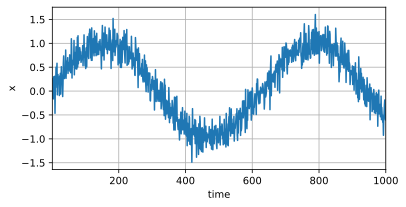

In [8]:
d2l.plot(time,[x],"time","x",xlim=[1,1000],figsize=(6,3))

In [9]:
tau=4
features=torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i]=x[i:T-tau+i]
labels=x[tau:].reshape((-1,1))

In [10]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)


In [11]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net


loss = nn.MSELoss()


In [12]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)


epoch 1, loss: 0.073500
epoch 2, loss: 0.062410
epoch 3, loss: 0.057373
epoch 4, loss: 0.057462
epoch 5, loss: 0.062731


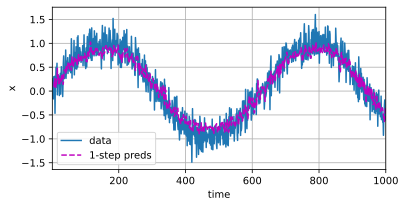

In [13]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))


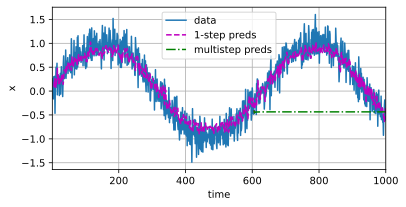

In [15]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds',
            'multistep preds'], xlim=[1, 1000], figsize=(6, 3))


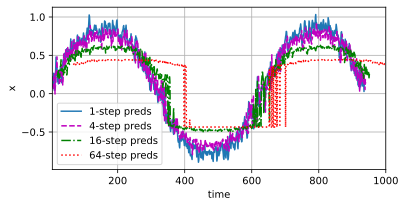

In [16]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))


In [ ]:
# 误差累加
# 难点:预测很远的未来
# RNN的隐变量是潜变量的一种
# tau=5比tau=4好 但是tau不一定越多越好
# tau越大，训练样本越少，模型变大，计算量变大 
# RNN markov 假设
# 因果推断
# 记住序列的MLP和RNN是没有意义的
# 长步预测差
# 故障检测(不是那么时序)
# 困难在于负类数据样本
# 物理数据预测物理模型难 数据点少